# EEG Setup
## Introduction
This tutorial assumes that you have a working wireless EEG headset streaming raw EEG data over WiFi. To receive and visualize the raw EEG data, your device must support the [Lab Streaming Layer](https://labstreaminglayer.org/#/). Please check with the device manufacturer to see if the device supports LSL. If it does not, you may need to use a third-party application to convert the raw EEG data to LSL format.
You will also need to ensure that both your EEG device and your device running this tutorial are connected to the same WiFi network to be able to receive the data.

In this tutorial we will start with learning how to stream and visualize raw data, we will then move on to filtering and processing the data.

## Streaming with LSL
The Lab Streaming Layer (LSL) is a system for the unified collection of measurement time series in research experiments that handles time synchronization, time-stamping, and event markers. It is a set of open-source tools for the recording, streaming, and sharing of time series data, and is widely used in the field of neuroscience. LSL is a great tool for streaming EEG data, as it allows for easy synchronization of data from multiple devices and sensors. Before starting, we recomend that you read the [LSL documentation](https://labstreaminglayer.readthedocs.io/info/getting_started.html) to get a better understanding of how LSL works.

Here, we will use the `pylsl` library to receive the raw EEG data. The pylsl library is a Python library that provides a simple interface for receiving data from LSL streams. It is a wrapper around the C++ LSL library, and provides a simple and easy-to-use interface for working with LSL streams in Python. 

Once your EEG device is streaming data over the WiFi network, you can use `pylsl` to identify the data stream corresponding to your EEG data and receive it. 
The following code looks for every `EEG` stream on the network and prints some useful information about it.  You can use this information to identify which stream is the correct one for you. 

In [25]:
from pylsl import StreamInlet, resolve_stream, StreamInfo, resolve_streams
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, lfilter_zi, firwin
from time import sleep
from typing import Optional, Callable, Tuple
from IPython.display import display, clear_output
plt.ion()

In [26]:
# Resolve EEG streams
streams = resolve_streams()

# Iterate through streams
print(f"Found {len(streams)} streams")
print("---------------")

for stream in streams:
    print("Stream Name:", stream.name())
    print("Stream Type:", stream.type())
    print("Stream ID:", stream.source_id())   # this should match your X.on Serial Number
    print("Stream Unique Identifier:", stream.uid())
    print("---------------")

Found 2 streams
---------------
Stream Name: X.on-102106-0035
Stream Type: EEG
Stream ID: 102106-0035 250
Stream Unique Identifier: 545b2848-4432-41da-a05c-b5e4b2b46a7c
---------------
Stream Name: X.on-102106-0035-Marker
Stream Type: Markers
Stream ID: 102106-0035 250 M
Stream Unique Identifier: faab5968-2db8-431a-8865-e8491c73570e
---------------


Next, we define a function to allow us to find the stream we are interested in. This function will look for a stream with a specific name and type, and return the first stream that matches the criteria.
Note that your function should also raise errors and provide messages to inform the user if the stream is not found. 

In [27]:
            
def get_lsl_stream(target_stream_name:str, n_attempts:int=100,) -> StreamInfo:
    """Get LSL API for given EEG stream name.
    
    Args:
        target_stream_name: String. Name of target stream.
        n_attempts: Int. Number of attempts to look for the stream.
    """
    
    print("looking for an EEG stream...")
    # Loop for a while to look for the EEG stream, because sometimes the stream
    # is not found by resolve_stream() even when it exists
    for _ in range(n_attempts):
        streams = resolve_stream('type', 'EEG')
        for stream in streams:
            if stream.name() == target_stream_name:
                print(f"Found {target_stream_name} stream")
                return stream
                break
            

    raise ValueError(f'Cannot find stream {target_stream_name}')


## Streaming and visualizing data 

stream: LSL data stream.
feature_extractor: Callable mapping data -> features.
window: Scalar. Window size in seconds for data caching and
    plotting.
buf: Int. Number of second for the data stream buffer.
subsample_plot: Int. Stride for subsampling data when plotting.

In [28]:
window: int=5
buf: int=1 
subsample_plot: int=3 
plot: bool=True

STREAM_NAME = "X.on-102106-0035"  # Replace with your stream name
stream: StreamInfo = get_lsl_stream(STREAM_NAME)


looking for an EEG stream...
Found X.on-102106-0035 stream


In [29]:
# createa a StreamInlet to get data from the stream
inlet = StreamInlet(stream, max_buflen=buf, max_chunklen=buf)

# General metadata about inlet stream
info = inlet.info()
sfreq = info.nominal_srate()
n_samples = int(sfreq * window)
n_chan = info.channel_count()

# Initialize variables for data and times
times = np.arange(-window, 0, 1. / sfreq)
data = np.zeros((n_samples, n_chan))


In [30]:
def pull_data(inlet: StreamInlet, times: np.ndarray, data: np.ndarray, 
              sfreq: int, window: int, n_samples: int, filter_fn:Optional[Callable]=None,) -> Tuple:
    samples, timestamps = inlet.pull_chunk(
            timeout=0.01, max_samples=24)
    while inlet.samples_available() > 50:
        samples, timestamps = inlet.pull_chunk(
            timeout=0.01, max_samples=24)
    
    if not (isinstance(timestamps, list) and len(timestamps) > 1):
        sleep(0.01)
        return times, data 
    
    # Dejitter and append times
    num_new_samples = len(timestamps)
    timestamps = np.float64(np.arange(num_new_samples)) / sfreq
    timestamps += times[-1] + 1. / sfreq
    times = np.concatenate([times, timestamps])
    n_samples = int(sfreq * window)
    times = times[-n_samples:]

    # potentially filter function
    if filter_fn is not None:
        samples = filter_fn(samples)
    
    # Add new data
    data = np.vstack([data, samples])
    data = data[-n_samples:]
    return times, data

Initialize for plotting

In [44]:
def update_plot(
    fig, times: np.ndarray, data: np.ndarray, lines_data: list, ax: plt.Axes, window: int, subsample_plot: int=3,
) -> None:
    ax.cla()

    # Update data plot
    plot_data = np.copy(data[::subsample_plot])
    plot_data -= np.nanmean(plot_data, axis=0, keepdims=True)
    plot_data /= 3 * np.nanstd(plot_data, axis=0, keepdims=True)
    for chan in range(data.shape[1]):
        ax.plot(
            times[::subsample_plot] - times[-1],
            plot_data[:, chan] - chan,
            color="C0",
            alpha=0.5,
        )
    ax.set_xlim(-window, 0)
    ax.set(title="Real-time EEG")

    # fig.canvas.draw()
    # plt.pause(0.01)
    
    display(fig)
    clear_output(wait = True)
    plt.pause(0.01)

    # display(fig)
    # clear_output(wait = True)
    # plt.pause(0.1)

Run a loop, pulling data and updating the plot. 

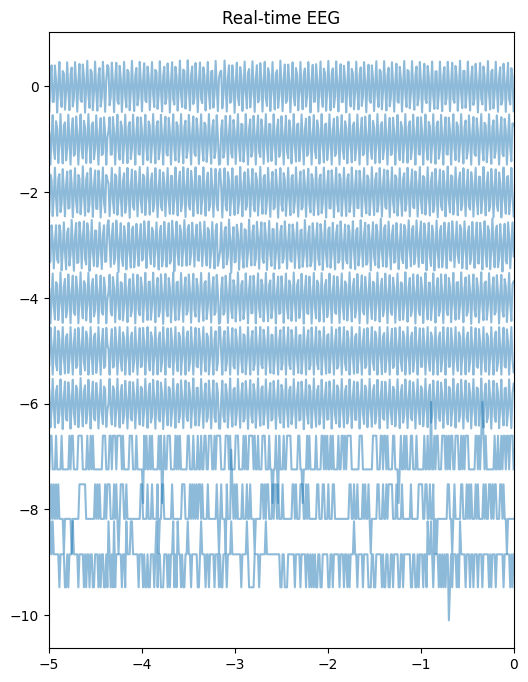

In [32]:
N_STEPS = 1000
UPDATE_PLOT_EVERY = int(0.2 / (12 / sfreq))

%matplotlib inline

fig, ax_raw = plt.subplots(figsize=(6, 8))
times_plot = times[::subsample_plot]

# Data lines
lines_data = []
for channel in range(n_chan):
    line, = ax_raw.plot(
        times_plot, np.zeros_like(times_plot) - channel, lw=1)
    lines_data.append(line)
lines_data = lines_data
ax_raw.set_ylim(-n_chan - 0.5, 0.5)
ax_raw.set_xlabel('Time (s)')
ax_raw.xaxis.grid(False)
ax_raw.set_yticks(np.arange(0, -n_chan, -1))


update_idx = 0 
for i in range(N_STEPS):
    times, data = pull_data(inlet, times, data, sfreq, window, n_samples)

    if update_idx % UPDATE_PLOT_EVERY == 0:
        update_plot(fig, times, data, lines_data, ax_raw, window, subsample_plot)
    update_idx += 1


## Filtering data

Filtering raw EEG data is crucial for extracting meaningful information and reducing noise artifacts, ensuring accurate interpretation and analysis of brain signals. Raw EEG signals often contain various sources of noise, including muscle activity, electrical interference, and environmental artifacts, which can obscure underlying neural activity. Filtering techniques help remove unwanted noise while preserving relevant neural information, enhancing the signal-to-noise ratio and improving the quality of EEG recordings. Commonly used types of filters include:

Bandpass Filters: Bandpass filters selectively attenuate frequencies outside of a specified range, allowing researchers to focus on the frequency bands of interest in EEG analysis. For example, alpha (8-12 Hz) and beta (12-30 Hz) bandpass filters are commonly used to isolate rhythmic brain activity associated with different cognitive states.

Notch Filters: Notch filters are used to suppress specific frequencies, typically powerline noise at 50 or 60 Hz and its harmonics, which can contaminate EEG recordings due to electrical interference from power sources. Notch filters help remove these unwanted artifacts, improving the signal quality.

High-pass Filters: High-pass filters attenuate low-frequency components in EEG signals, such as slow drifts and baseline fluctuations, while preserving higher-frequency neural activity. High-pass filtering helps remove baseline wander and DC offsets, ensuring a stable baseline for subsequent analysis.

Low-pass Filters: Low-pass filters attenuate high-frequency noise and artifacts, such as muscle activity and electrode movement, while preserving slow-wave components of EEG signals. Low-pass filtering helps smoothen the EEG signal and reduce high-frequency noise, improving signal clarity.

By applying appropriate filtering techniques, researchers can enhance the interpretability and reliability of EEG data, enabling more accurate analysis and insights into brain function and behavior. Effective filtering is essential for unlocking the full potential of EEG-based research and applications in neuroscience, clinical diagnostics, and brain-computer interfaces.


Here, we will filter the data with a finite impulse response filter. 

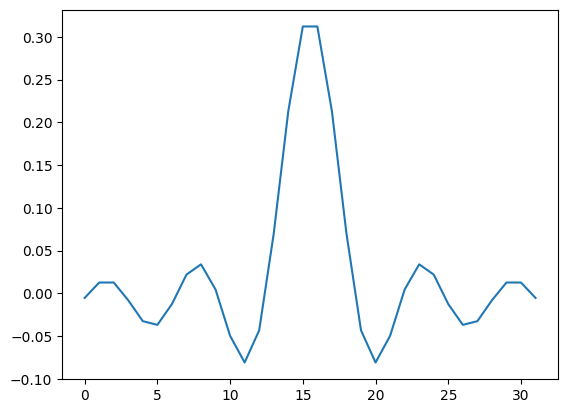

In [33]:
# initialize variables for filtering
bf: np.ndarray = firwin(
    32,
    np.array([1, 40]) / (sfreq / 2.),
    width=0.05,
    pass_zero=False,
)
af: list = [1.0]
zi: np.ndarray = lfilter_zi(bf, af)
filt_state: np.ndarray = np.tile(zi, (n_chan, 1)).transpose()

# plot the filter to see its shape
plt.plot(bf)

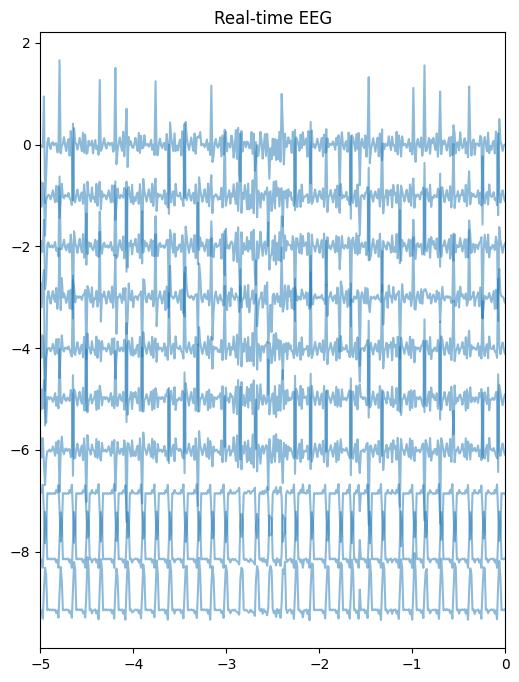

In [34]:
def filter_samples(samples: np.ndarray, af:list, bf: np.ndarray, filt_state: np.ndarray) -> np.ndarray:
    return lfilter(
            bf, af, samples, axis=0, zi=filt_state
    )[0]
    

# define a lambda function for simplicity
_filter_samples = lambda samples: filter_samples(samples, af, bf, filt_state)


# now do the same as before, but with the filter function
fig, ax_raw = plt.subplots(figsize=(6, 8))
times_plot = times[::subsample_plot]

# Data lines
lines_data = []
for channel in range(n_chan):
    line, = ax_raw.plot(
        times_plot, np.zeros_like(times_plot) - channel, lw=1)
    lines_data.append(line)
lines_data = lines_data
ax_raw.set_ylim(-n_chan - 0.5, 0.5)
ax_raw.set_xlabel('Time (s)')
ax_raw.xaxis.grid(False)
ax_raw.set_yticks(np.arange(0, -n_chan, -1))

update_idx = 0
for _ in range(N_STEPS):
    times, data  = pull_data(inlet, times, data, sfreq, window, n_samples, filter_fn=_filter_samples)

    if update_idx % UPDATE_PLOT_EVERY == 0:
        update_plot(fig, times, data, lines_data, ax_raw, window, subsample_plot)
    update_idx += 1


Play around with the filter parameters to see how that affects the data!

## Features
Beyond filtering, before passing the data to a machine learning model, we may want to extract features from the data.
Feature extraction is the process of transforming raw data into a set of features that capture relevant information for a specific task or application. 
In this case, we will take the rolling standard deviation of each EEG channel (which roughly corresponds to the envelope of the EEG)

In [35]:
# initialize some variables
recent_stddevs = []
baseline_stddevs = None
n_features = 7  # will be specific to the EEG headset you're using
history_chunks=100  #  Number of recent data chunks to use for computing the baseline stddev per channel.
 
# define a function
def extract_features(data: np.ndarray, recent_stddevs: list, baseline_stddevs: Optional[np.ndarray]=None, n_features: int=7, history_chunks: int=100) -> tuple:
    """Process batch of data of shape [timesteps_per_chunk, n_features]."""
    
    # Trim unused channels
    data = data[:, :n_features]
    
    # Zero-mean the data
    data -= np.nanmean(data, axis=0, keepdims=True)
    
    # Compute current stddevs
    current_stddevs = np.nanstd(data, axis=0)

    # Compute baseline (mean) stddev per channel
    if baseline_stddevs is None:
        recent_stddevs.append(current_stddevs)
        if len(recent_stddevs) > history_chunks:
            recent_stddevs.pop(0)
        baseline_stddevs = np.mean(recent_stddevs, axis=0)
    else:
        baseline_stddevs = baseline_stddevs
    
    # Features are normalized stddevs
    features = current_stddevs / baseline_stddevs

    return features, baseline_stddevs, recent_stddevs
    


Now we run the loop as again, but we keep track of both the filtered data and the features

In [42]:
features = np.zeros((n_samples, n_features))

def update_features(
    data: np.ndarray, features: np.ndarray, baseline_stddevs: np.ndarray, recent_stddevs: list, n_channels: int=7, history_chunks: int=100,
) -> tuple:
    new_features, baseline_stddevs, recent_stddevs = extract_features(
        data, recent_stddevs, baseline_stddevs, n_channels, history_chunks
    )
    features = np.vstack([features, new_features])
    features = features[-n_samples:]
    return features, baseline_stddevs, recent_stddevs




Create a new figure with an ax to plot the features. 


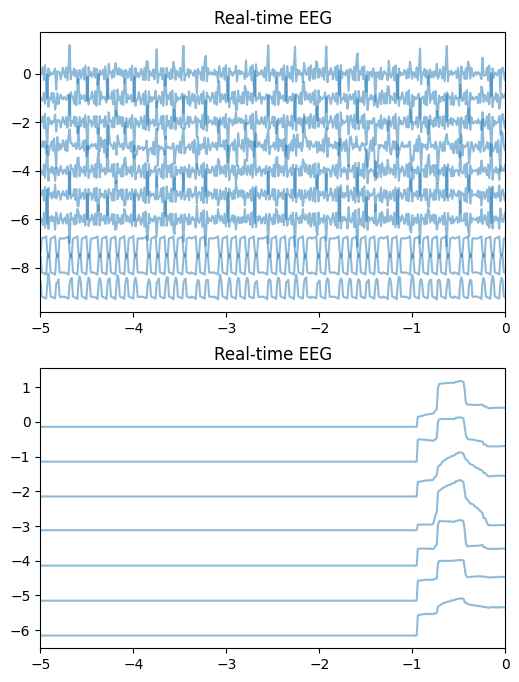

In [45]:

fig, axes = plt.subplots(2, 1, figsize=(6, 8))
ax_raw, ax_feat = axes
times_plot = times[::subsample_plot]

# Data lines
lines_data = []
for channel in range(n_chan):
    line, = ax_raw.plot(
        times_plot, np.zeros_like(times_plot) - channel, lw=1)
    lines_data.append(line)
lines_data = lines_data
ax_raw.set_ylim(-n_chan - 0.5, 0.5)
ax_raw.set_xlabel('Time (s)')
ax_raw.xaxis.grid(False)
ax_raw.set_yticks(np.arange(0, -n_chan, -1))

# Feature lines
lines_feat = []
for channel in range(n_features):
    line, = ax_feat.plot(
        times_plot, np.zeros_like(times_plot) - channel, lw=1)
    lines_feat.append(line)
lines_feat = lines_feat
ax_feat.set_ylim(-n_features - 0.5, 0.5)
ax_feat.set_xlabel('Time (s)')
ax_feat.xaxis.grid(False)
ax_feat.set_yticks(np.arange(0, -n_features, -1))


# now do the same as before, but with the filter function
for _ in range(N_STEPS):
    times, data  = pull_data(inlet, times, data, sfreq, window, n_samples, filter_fn=_filter_samples)
    features, baseline_stddevs, recent_stddevs = update_features(
        data, features, baseline_stddevs, recent_stddevs, n_features, history_chunks
    )

    if update_idx % UPDATE_PLOT_EVERY == 0:
        update_plot(fig, times, data, lines_data, ax_raw, window, subsample_plot)
        update_plot(fig, times, features, lines_feat, ax_feat, window, subsample_plot)
    update_idx += 1

## Conclusion
In the next tutorial we will design and implement a simple machine learning model and we will write some code to generate the data we need to train it.
